In [4]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import ast
%matplotlib notebook

In [94]:
def load_behavior_data(behavPath,session_num):
    # behavior/stimuli

    f = h5py.File(behavPath,'r')
    
    trialEndFrame = f['trialEndFrame'][:]
    nTrials = trialEndFrame.size
    trialStartFrame = f['trialStartFrame'][:nTrials]
    startTime = f['startTime'][()]
    
    rigName = f['rigName'][()]
    
    #vis params
    trialVisStimFrames = f['trialVisStimFrames'][:nTrials]
    
    #sound params
    trialSoundDur = f['trialSoundDur'][:nTrials]
    trialSoundArray = f['trialSoundArray'][:nTrials]
    trialSoundFreq = f['trialSoundFreq'][:nTrials]
    soundSampleRate = f['soundSampleRate'][()]

    #behavior stuff
    lickFrames=f['lickFrames'][:]
    rewardFrames=f['rewardFrames'][:]
    trialAutoRewarded=f['trialAutoRewarded'][:]
    responseWindow=f['responseWindow'][:]

    blockStim=f['blockStim'][:].astype('str')
    blockStimRewarded=f['blockStimRewarded'][:].astype('str')
    trialBlock=f['trialBlock'][:nTrials]
    trialStimID=f['trialStim'][:nTrials].astype('str')
    trialBlockRewarded=blockStimRewarded[trialBlock-1]
    trialStimStartFrame=f['trialStimStartFrame'][:nTrials]
    trialEndFrame=f['trialEndFrame'][:nTrials]
    
    opto_vars=0
    if 'trialGalvoVoltage' in list(f.keys()):
        opto_vars=1
        trialGalvoVoltage=f['trialGalvoVoltage'][:nTrials]
        trialOptoDur=f['trialOptoDur'][:nTrials]
        trialOptoOnsetFrame=f['trialOptoOnsetFrame'][:nTrials]
        trialOptoVoltage=f['trialOptoVoltage'][:nTrials]
        galvoVoltage=f['galvoVoltage'][:nTrials]
    
        if 'optoRegions' in list(f.keys()):
            optoRegions = f['optoRegions'][()]
            trialOptoRegion = []
            for tt in range(0,nTrials):
                galvo_matched=0
                for io,oo in enumerate(galvoVoltage):
                    if np.all(trialGalvoVoltage[tt]==oo):
                        trialOptoRegion.append(optoRegions[io])
                        galvo_matched=1
                        break
                if galvo_matched==0:
                    trialOptoRegion.append('')
            trialOptoRegion=np.asarray(trialOptoRegion)
    
    if len(f['rotaryEncoderCount'][:])>0:
        wheelPos=(f['rotaryEncoderCount'][:]/f['rotaryEncoderCountsPerRev'][()])*(2*np.pi*f['wheelRadius'][()])*60
        deltaWheelPos=np.zeros((len(wheelPos)))
        deltaWheelPos[1:]=wheelPos[1:]-wheelPos[:-1]
    else:
        deltaWheelPos=[]
    
    if type(blockStim)==str:
        blockStim=ast.literal_eval(blockStim)
    for xx in range(0,len(blockStim)):
        if type(blockStim[xx])==str:
            blockStim[xx]=ast.literal_eval(blockStim[xx])
    
    f.close()
    
    #re-generate trial sound arrays if I forgot to save them (only early pilot recordings)
    # assumes sound1=6kHz and sound2=10kHz
    if len(trialSoundArray)==0:
        soundHanningDur = 0.005 # seconds
    
        trialSoundArray=[]
    
        for it,tt in enumerate(trialSoundDur):
            t = np.arange(0,tt,1/soundSampleRate)
            soundArray = np.sin(2 * np.pi * trialSoundFreq[it,0] * t)
    
            if len(soundArray)>0:
                hanningSamples = int(soundSampleRate * soundHanningDur)
                hanningWindow = np.hanning(2 * hanningSamples + 1)
                soundArray[:hanningSamples] *= hanningWindow[:hanningSamples]
                soundArray[-hanningSamples:] *= hanningWindow[hanningSamples+1:]
    
            trialSoundArray.append(soundArray)
    
    
    #define hit/miss/fa/cr/autoreward trials
    unique_blocks=np.unique(trialBlock)
    
    #specify vis go/nogo, aud go/nogo
    vis_go_trials=np.zeros((nTrials)).astype('bool')
    vis_nogo_trials=np.zeros((nTrials)).astype('bool')
    vis_hit_trials=np.zeros((nTrials)).astype('bool')
    vis_false_alarm_trials=np.zeros((nTrials)).astype('bool')
    vis_miss_trials=np.zeros((nTrials)).astype('bool')
    vis_correct_reject_trials=np.zeros((nTrials)).astype('bool')
    vis_autoreward_trials=np.zeros((nTrials)).astype('bool')
    # vis_manualreward_trials=np.zeros((nTrials)).astype('bool')
    
    aud_go_trials=np.zeros((nTrials)).astype('bool')
    aud_nogo_trials=np.zeros((nTrials)).astype('bool')
    aud_hit_trials=np.zeros((nTrials)).astype('bool')
    aud_false_alarm_trials=np.zeros((nTrials)).astype('bool')
    aud_miss_trials=np.zeros((nTrials)).astype('bool')
    aud_correct_reject_trials=np.zeros((nTrials)).astype('bool')
    aud_autoreward_trials=np.zeros((nTrials)).astype('bool')
    # aud_manualreward_trials=np.zeros((nTrials)).astype('bool')
    
    catch_trials=np.zeros((nTrials)).astype('bool')
    catch_resp_trials=np.zeros((nTrials)).astype('bool')
    
    trial_response=np.zeros((nTrials)).astype('bool')
    trial_rewarded=np.zeros((nTrials)).astype('bool')
    
    block=[]
    stim_rewarded=[]
    
    for bb in range(0,len(unique_blocks)):
        
        blockTrialStart=np.where(trialBlock==unique_blocks[bb])[0][0]
        blockTrialEnd=np.where(trialBlock==unique_blocks[bb])[0][-1]+1
        
        for tt in range(blockTrialStart,blockTrialEnd):
            block.append(bb)
            stim_rewarded.append(blockStimRewarded[bb])
            
            if (tt>=len(trialEndFrame)):
                break
            temp_start_frame=trialStimStartFrame[tt]-250 #preStimFramesFixed
            temp_end_frame=trialEndFrame[tt]
    
            temp_licks=[]
            
            if len(lickFrames)>0:
                temp_licks=np.copy(lickFrames)
                temp_licks=temp_licks[(temp_licks>temp_start_frame)&(temp_licks<temp_end_frame)]-trialStimStartFrame[tt]
    
            if len(rewardFrames)>0:
                temp_reward=np.copy(rewardFrames)
                temp_reward=temp_reward[(temp_reward>temp_start_frame)&(temp_reward<temp_end_frame)]-trialStimStartFrame[tt]

            temp_RW_lick=0
            for ii in temp_licks:
                if (ii>=responseWindow[0])&(ii<=responseWindow[1]):
                    temp_RW_lick=1
                    trial_response[tt]=True
                    
            for rr in temp_reward:
                if (rr>=responseWindow[0]):
                    trial_rewarded[tt]=True
    
            #visual-go block
            if (trialStimID[tt] == 'vis1'):
                vis_go_trials[tt]=True
                if ~trialAutoRewarded[tt]:
                    if temp_RW_lick:
                        vis_hit_trials[tt]=True
                    else:
                        vis_miss_trials[tt]=True
                else:
                    vis_autoreward_trials[tt]=True
    
    
            elif (trialStimID[tt] == 'vis2'):
                vis_nogo_trials[tt]=True
                if temp_RW_lick:
                    vis_false_alarm_trials[tt]=True
                else:
                    vis_correct_reject_trials[tt]=True
    
    
            elif trialStimID[tt] == 'catch':
                catch_trials[tt]=True
                if temp_RW_lick:
                    catch_resp_trials[tt]==True
    
            elif ('sound1' in trialStimID[tt]):
                aud_go_trials[tt]=True
                if ~trialAutoRewarded[tt]:
                    if temp_RW_lick:
                        aud_hit_trials[tt]=True
                    else:
                        aud_miss_trials[tt]=True
                else:
                    aud_autoreward_trials[tt]=True
    
            elif ('sound2' in trialStimID[tt]):
                aud_nogo_trials[tt]=True
                if ~trialAutoRewarded[tt]:
                    if temp_RW_lick:
                        aud_false_alarm_trials[tt]=True
                    else:
                        aud_correct_reject_trials[tt]=True
                else:
                    aud_autoreward_trials[tt]=True
    
    
    trials_dict={
        'trialStartFrame':trialStartFrame,
        'trialStimID':trialStimID,
        'trialstimRewarded':stim_rewarded,
        'trial_response':trial_response,
        'trial_rewarded':trial_rewarded,
        'trial_sound_dur':trialSoundDur,
        'trial_vis_stim_dur':trialVisStimFrames/60,
        
        'vis_go_trials':vis_go_trials,
        'vis_nogo_trials':vis_nogo_trials,
        'vis_hit_trials':vis_hit_trials,
        'vis_false_alarm_trials':vis_false_alarm_trials,
        'vis_miss_trials':vis_miss_trials,
        'vis_correct_reject_trials':vis_correct_reject_trials,
        'vis_autoreward_trials':vis_autoreward_trials,
    
        'aud_go_trials':aud_go_trials,
        'aud_nogo_trials':aud_nogo_trials,
        'aud_hit_trials':aud_hit_trials,
        'aud_false_alarm_trials':aud_false_alarm_trials,
        'aud_miss_trials':aud_miss_trials,
        'aud_correct_reject_trials':aud_correct_reject_trials,
        'aud_autoreward_trials':aud_autoreward_trials,
        
        'catch_trials':catch_trials,
        'catch_resp_trials':catch_resp_trials,
        
        'trialStimStartFrame':trialStimStartFrame,
    }
    
    trials_df=pd.DataFrame.from_dict(trials_dict)
    
    if opto_vars:
        trials_df['trialGalvoVoltage_x']=trialGalvoVoltage[:,0]
        trials_df['trialGalvoVoltage_y']=trialGalvoVoltage[:,1]
        trials_df['trialOptoDur']=trialOptoDur
        trials_df['trialOptoOnsetFrame']=trialOptoOnsetFrame
        trials_df['trialOptoVoltage']=trialOptoVoltage
        
        if 'trialOptoRegion' in locals():
            trials_df['trialOptoRegion']=trialOptoRegion
    
    
    
        trials_df=trials_df.query('trialOptoVoltage.isnull()')
    
    
    vis_block_trials=trials_df.query('trialstimRewarded == "vis1" and vis_autoreward_trials == False')
    aud_block_trials=trials_df.query('trialstimRewarded == "sound1" and aud_autoreward_trials == False')

    vis_target_vis_block = np.mean(vis_block_trials.query('trialStimID == "vis1"')['trial_response'])
    vis_nontarget_vis_block = np.mean(vis_block_trials.query('trialStimID == "vis2"')['trial_response'])
    vis_target_aud_block = np.mean(aud_block_trials.query('trialStimID == "vis1"')['trial_response'])
    vis_nontarget_aud_block = np.mean(aud_block_trials.query('trialStimID == "vis2"')['trial_response'])
    
    aud_target_aud_block = np.mean(aud_block_trials.query('trialStimID == "sound1"')['trial_response'])
    aud_nontarget_aud_block = np.mean(aud_block_trials.query('trialStimID == "sound2"')['trial_response'])
    aud_target_vis_block = np.mean(vis_block_trials.query('trialStimID == "sound1"')['trial_response'])
    aud_nontarget_vis_block = np.mean(vis_block_trials.query('trialStimID == "sound2"')['trial_response'])
    
    summary_dict={
        
        'session':session_num,
        
        'startTime':np.asarray(startTime).astype(str),
    
        'rigName':np.asarray(rigName).astype(str),
        
        'n_trials':len(trials_df),
        
        'vis_target_vis_block':vis_target_vis_block, 
        'vis_nontarget_vis_block':vis_nontarget_vis_block, 
        'vis_target_aud_block':vis_target_aud_block, 
        'vis_nontarget_aud_block':vis_nontarget_aud_block, 

        'aud_target_aud_block':aud_target_aud_block,
        'aud_nontarget_aud_block':aud_nontarget_aud_block,
        'aud_target_vis_block':aud_target_vis_block,
        'aud_nontarget_vis_block':aud_nontarget_vis_block,
        
    }
    
    summary_df = pd.DataFrame(summary_dict,index=[session_num])
    
    return summary_df
    
    

In [85]:
# path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\DynamicRoutingTask\Data\644866\DynamicRouting1_644866_20230210_114544.hdf5"
# session_num=0
# summary_df=load_behavior_data(path,session_num)

In [86]:
summary_df

,session,startTime,rigName,vis_target_vis_block,vis_nontarget_vis_block,vis_target_aud_block,vis_nontarget_aud_block,aud_target_aud_block,aud_nontarget_aud_block,aud_target_vis_block,aud_nontarget_vis_block
0,0,20230210_114544,NP3,0.983333,0.090909,0.339286,0.054545,1.0,0.981132,0.275862,0.107143


In [113]:

paths = [
    r"D:\DynamicRoutingTask\Data\626791",
    r"D:\DynamicRoutingTask\Data\636766",
    r"D:\DynamicRoutingTask\Data\644864",
    r"D:\DynamicRoutingTask\Data\644866",
    r"D:\DynamicRoutingTask\Data\644867",
    r"D:\DynamicRoutingTask\Data\649943",
        ]

n_recs={
    '626791':3,'636766':4,'644864':4,'644866':4,'644867':4,'649943':4,
}

all_mice_summary={}

for p in paths:
    
    all_sessions=[]
    filenames = [f for f in os.listdir(p) if (os.path.isfile(os.path.join(p, f)))&('DynamicRouting1' in f)]

    for fi,ff in enumerate(filenames):
        temp_summary=load_behavior_data(os.path.join(p, ff),fi)
        all_sessions.append(temp_summary)
        
    all_sessions = pd.concat(all_sessions,axis=0)
    
    all_mice_summary[p[-6:]]=all_sessions
    

In [98]:
# all_sessions[1]

In [155]:
all_mice_summary['636766']['rigName'].values

array(['B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3',
       'B3', 'B3', 'B3', 'B3', 'B3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3',
       'NP3', 'NP3', 'NP3', 'NP3', 'B1', 'B1', 'NP3', 'NP3', 'NP3', 'NP3',
       'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3',
       'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3', 'NP3',
       'NP3', 'NP3', 'NP3', 'NP3'], dtype=object)

In [154]:
all_mice_summary[sel_mouse]

,session,startTime,rigName,n_trials,vis_target_vis_block,vis_nontarget_vis_block,vis_target_aud_block,vis_nontarget_aud_block,aud_target_aud_block,aud_nontarget_aud_block,aud_target_vis_block,aud_nontarget_vis_block
0,0,20220808_083530,B3,150,NaN,0.638889,NaN,NaN,NaN,NaN,NaN,NaN
1,1,20220809_083030,B3,506,0.180412,0.243243,NaN,NaN,NaN,NaN,NaN,NaN
2,2,20220810_081859,B3,364,0.946667,0.919540,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20220811_082954,B3,388,1.000000,0.954704,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20220812_080928,B3,456,1.000000,0.838806,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
103,103,20230120_145155,NP3,223,1.000000,0.272727,0.380952,0.050000,1.000000,0.045455,0.454545,0.15
104,104,20230123_120618,NP3,218,0.952381,0.238095,0.523810,0.100000,0.950000,0.095238,0.227273,0.00
105,105,20230124_121705,NP3,220,0.772727,0.047619,0.238095,0.045455,1.000000,0.050000,0.350000,0.00
106,106,20230125_130602,NP3,223,0.900000,0.300000,0.681818,0.090909,0.913043,0.000000,0.318182,0.00


<IPython.core.display.Javascript object>


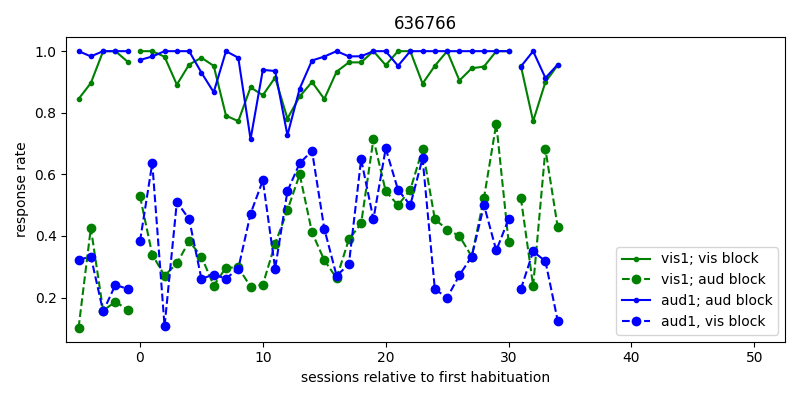

In [156]:
sel_mouse='636766'

# def plot_mouse_summary(sel_mouse):

if sel_mouse=='636766':
    retrain_sessions=all_mice_summary[sel_mouse].query('rigName == "B1"').index
    all_mice_summary[sel_mouse]=all_mice_summary[sel_mouse].drop(index=retrain_sessions)
    

NP=np.where(all_mice_summary[sel_mouse]['rigName']=='NP3')[0]

if sel_mouse=='644867':
    NP=NP[3:]

first_NP=NP[0]

first_rec=len(all_mice_summary[sel_mouse])-n_recs[sel_mouse]

box_x=np.arange(-5,0)
hab_x=np.arange(0,len(NP)-n_recs[sel_mouse])
rec_x=np.arange(len(NP)-n_recs[sel_mouse],len(NP))

fig,ax=plt.subplots(figsize=(8,4))

#sessions in box
ax.plot(box_x,all_mice_summary[sel_mouse]['vis_target_vis_block'][first_NP-5:first_NP],'g.-')
ax.plot(box_x,all_mice_summary[sel_mouse]['vis_target_aud_block'][first_NP-5:first_NP],'g--o')
ax.plot(box_x,all_mice_summary[sel_mouse]['aud_target_aud_block'][first_NP-5:first_NP],'b.-')
ax.plot(box_x,all_mice_summary[sel_mouse]['aud_target_vis_block'][first_NP-5:first_NP],'b--o')

#hab sessions
ax.plot(hab_x,all_mice_summary[sel_mouse]['vis_target_vis_block'][first_NP:first_NP+len(hab_x)],'g.-')
ax.plot(hab_x,all_mice_summary[sel_mouse]['vis_target_aud_block'][first_NP:first_NP+len(hab_x)],'g--o')
ax.plot(hab_x,all_mice_summary[sel_mouse]['aud_target_aud_block'][first_NP:first_NP+len(hab_x)],'b.-')
ax.plot(hab_x,all_mice_summary[sel_mouse]['aud_target_vis_block'][first_NP:first_NP+len(hab_x)],'b--o')

#rec sessions
ax.plot(rec_x,all_mice_summary[sel_mouse]['vis_target_vis_block'][first_NP+len(hab_x):first_NP+len(hab_x)+len(NP)],'g.-')
ax.plot(rec_x,all_mice_summary[sel_mouse]['vis_target_aud_block'][first_NP+len(hab_x):first_NP+len(hab_x)+len(NP)],'g--o')
ax.plot(rec_x,all_mice_summary[sel_mouse]['aud_target_aud_block'][first_NP+len(hab_x):first_NP+len(hab_x)+len(NP)],'b.-')
ax.plot(rec_x,all_mice_summary[sel_mouse]['aud_target_vis_block'][first_NP+len(hab_x):first_NP+len(hab_x)+len(NP)],'b--o')


ax.set_ylabel('response rate')
ax.set_xlabel('sessions relative to first habituation')
ax.set_xlim([-6,len(NP)*1.5])
ax.set_title(sel_mouse)
ax.legend(['vis1; vis block','vis1; aud block','aud1; aud block','aud1, vis block'],loc='lower right')
fig.tight_layout()



In [151]:
NP

array([ 71,  72,  73,  74,  75,  76,  77,  78,  79,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107], dtype=int64)

<IPython.core.display.Javascript object>


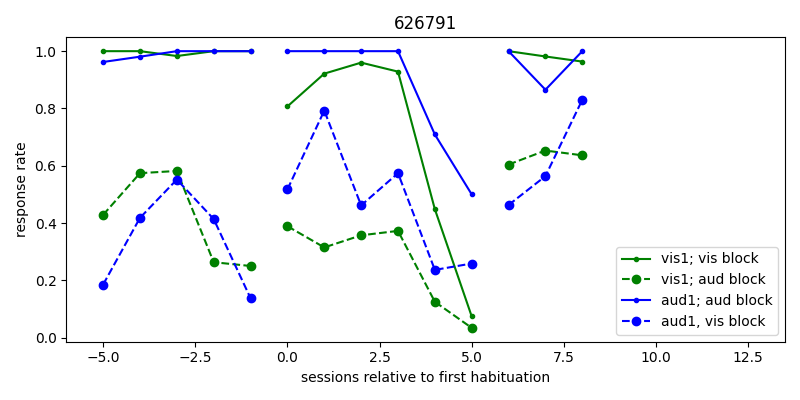

<IPython.core.display.Javascript object>


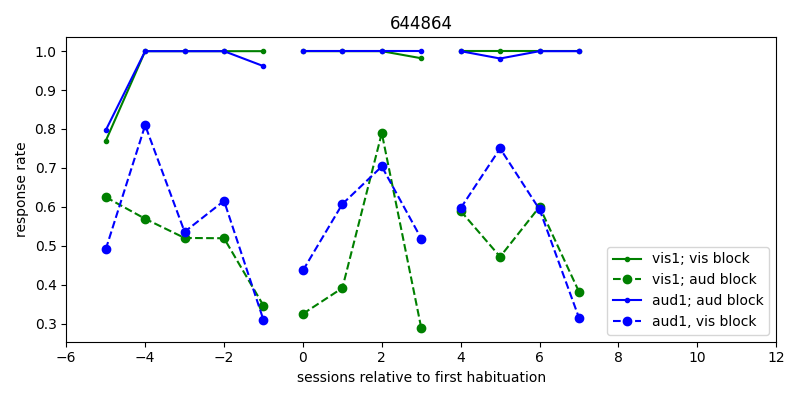

<IPython.core.display.Javascript object>


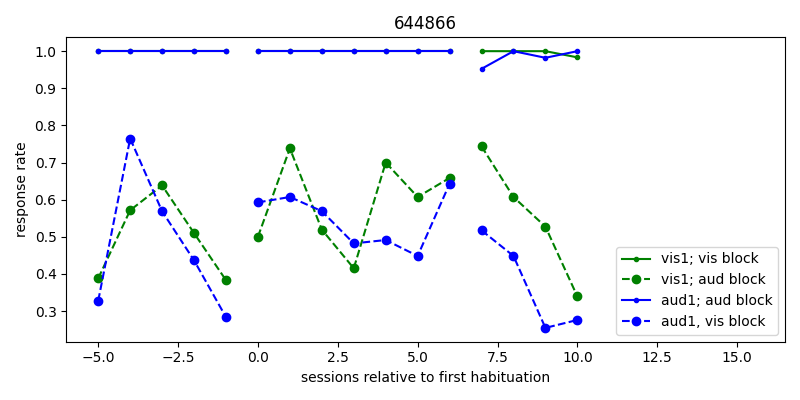

<IPython.core.display.Javascript object>


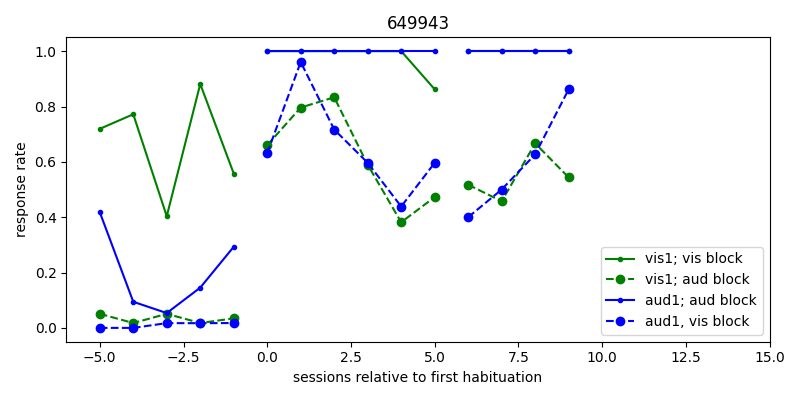

In [142]:
for ss in all_mice_summary.keys():
    if (ss=='636766')|(ss=='644867'):
        continue
    plot_mouse_summary(ss)

In [111]:
first_NP

array([34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)